In [223]:
import pickle
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from joblib import Parallel,delayed

In [224]:
path = '../data/data_emas_all_duration_day_v6.p'
data1 = pickle.load(open(path,'rb'))

In [225]:
import numpy as np
import pylab as pb
import GPy 
%pylab inline
def get_predictions(X,Y,error):
    X = (X - np.mean(X))/np.std(X)
    mm = np.mean(Y)
    ss = np.std(Y)
    Y = (Y-np.mean(Y))/ss
    kern =  GPy.kern.RBF(input_dim=1)
    Y_meta = {'output_index':np.arange(len(Y))[:,None]}
    m = GPy.models.GPHeteroscedasticRegression(X[:,None],Y[:,None],kern,Y_metadata=Y_meta)
    m['.*het_Gauss.variance'] = np.abs(error)[:,None] #Set the noise parameters to the error in Y
    m.het_Gauss.variance.fix() #We can fix the noise term, since we already know it
    m.optimize()
    preds,varss  = m.predict(m.X,full_cov=False,Y_metadata=None,kern=None,likelihood=None,include_likelihood=False)
    return preds*ss+mm,varss



def get_data(data):
    final_data = []
    df = pd.DataFrame({'duration':data[0],'data':data[1],'ema':data[2],'user':data[3],'hand':data[4]})

    from scipy.stats import iqr
    def get_weighted_rr_features(a):
#         f = np.percentile(a[:len(a)//2,0],80)/np.percentile(a[(len(a)//2):,0],80)
#         a = np.repeat(a[:,0],np.int64(np.round(100*a[:,1])))
        a = a[:,0]
        return np.array([
                         np.mean([np.percentile(a,80),np.percentile(a,50)]),
                         np.mean([np.percentile(a,60),np.percentile(a,50)]),
                         np.mean([np.percentile(a,80),np.percentile(a,50),np.mean(a)]),                            
                         np.var(a),
                         iqr(a),
                         np.mean(a),
                         np.median(a),
                         np.percentile(a,80),
                         np.percentile(a,20),
                         np.max(a),
                         skew(a),
                         kurtosis(a),
                         a[0],
                         a[-1],
                         a[len(a)//2]])
    
#     def get_feature1(a):
# #         try:
#         a = a[['time','stress_likelihood_ppg_qual','quality_mag']].dropna()
#         if a.shape[0]<5:
#             return np.nan
#         preds = get_predictions(a['time'].values,a['stress_likelihood_ppg_qual'].values,(1-a['quality_mag'].values)/6)
#         a['stress_likelihood_ppg_qual_final'] = preds[0]
#         plt.plot(a['time'],preds[0])
#         plt.show()
#         return a
#         except:
#             return np.nan
    
#     def get_feature(a):
#         try:
# #             print(a.columns)
#             a = a[['stress_likelihood_ppg_no_norm_qual','quality_mag']].dropna().values
            
#             return get_weighted_rr_features(a)
#         except:
#             return np.nan
        
    def get_feature(a,f='stress_likelihood_ppg_qual'):
        try:
#             print(a.columns)
            a = a[[f,'quality_mag']].dropna().values
            
            return get_weighted_rr_features(a)
        except:
            return np.nan
        
#     def get_feature2(a):
#         try:
# #             print(a.columns)
#             a = a[['stress_likelihood_ppg_no_norm_no_qual','quality_mag']].dropna().values
            
#             return get_weighted_rr_features(a)
#         except:
#             return np.nan
    
    
    def get_quality(a):
        try:
            a = a['quality_mag'].dropna().values
            return np.percentile(a,80)
        except:
            return np.nan

    for i,data2 in list(df.groupby('user',as_index=False)):
        data2['Quality Weighted, Reduced Features'] = data2['data'].apply(lambda a:get_feature(a,f='stress_likelihood_ppg_no_norm_qual'))
        data2['Quality Weighted, All Features'] = data2['data'].apply(lambda a:get_feature(a,f='stress_likelihood_ppg_no_norm_qual_all_features'))
        data2['Not Quality Weighted, Reduced Features'] = data2['data'].apply(lambda a:get_feature(a,f='stress_likelihood_ppg_no_norm_no_qual'))
        data2['Not Quality Weighted, All Features'] = data2['data'].apply(lambda a:get_feature(a,f='stress_likelihood_ppg_no_norm_no_qual_all_features'))
#         data2['Quality Weighted, Reduced Features, Post Processed'] = data2['data'].apply(lambda a:get_feature(a,f='stress_likelihood_ppg_no_norm_qual_weighted'))
#         data2['Quality Weighted, All Features, Post Processed'] = data2['data'].apply(lambda a:get_feature(a,f='stress_likelihood_ppg_no_norm_qual_all_features_weighted'))
#         data2['Not Quality Weighted, Reduced Features, Post Processed'] = data2['data'].apply(lambda a:get_feature(a,f='stress_likelihood_ppg_no_norm_no_qual_weighted'))
#         data2['Not Quality Weighted, All Features, Post Processed'] = data2['data'].apply(lambda a:get_feature(a,f='stress_likelihood_ppg_no_norm_no_qual_all_features_weighted'))
        data2['score'] = data2['ema'].apply(lambda a:a['score'])
        data2['label'] = data2['ema'].apply(lambda a:a['label'])
        data2['probs_mean'] = data2['data'].apply(lambda a:np.mean(np.repeat(a['quality_mag'],np.round(100*a['quality_mag']))))
#         data2['probs_80'] = data2['data'].apply(lambda a:np.percentile(np.repeat(a['probs'],np.round(100*a['quality_mag'])),80))
        data2['probs_20'] = data2['data'].apply(lambda a:np.percentile(a['quality_mag'],50))
        data2['probs_80'] = data2['data'].apply(lambda a:np.percentile(a['quality_mag'],50))
#         print(data2['label'].values)
        data2['quality'] = data2['data'].apply(lambda a:get_quality(a))
        data2 = data2[['duration','user','quality','hand','score',
                       'label','data','probs_mean','probs_80','probs_20',
                       'Quality Weighted, Reduced Features','Quality Weighted, All Features',
                      'Not Quality Weighted, Reduced Features','Not Quality Weighted, All Features']].dropna()
#         print(data2.info())
        final_data.append(data2)
    return final_data
output = Parallel(n_jobs=30,verbose=3)(delayed(get_data)(data) for data in data1)
# output = [get_data(data) for data in data1[:1]]
final_data = []
for r in output:
    final_data.extend(r)
#     print(data['feature'])
# data['ema'].loc[547]

Populating the interactive namespace from numpy and matplotlib


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  11 | elapsed:   24.5s remaining:   42.8s
[Parallel(n_jobs=30)]: Done   8 out of  11 | elapsed:   27.5s remaining:   10.3s
[Parallel(n_jobs=30)]: Done  11 out of  11 | elapsed:   30.2s finished


In [226]:
data = pd.concat(final_data)
def get_labels(df):
    df = df.dropna().sort_values('score').reset_index(drop=True)
    if df.shape[0]<10:
        return pd.DataFrame([],columns=df.columns)
    if np.sum(df['label'])<3:
        return pd.DataFrame([],columns=df.columns)
    if len(np.unique(df['label'].values))<2:
        return pd.DataFrame([],columns=df.columns)
    return df
data_global = data.groupby(['user','duration'],as_index=False).apply(get_labels)

In [227]:
data_global.duration.unique()

array([20, 25, 30, 35, 40, 45, 50, 55, 60, 10, 15], dtype=object)

In [228]:
# data = data_global
# data[['user','duration']].groupby(['duration']).count()
data_global.head()

duration                                  user   quality   hand  score  \
13 0       20  02543bbf-84c2-4076-8547-c8a5f451ea02  0.353422   left    2.4   
   1       20  02543bbf-84c2-4076-8547-c8a5f451ea02  0.302614  right    2.4   
   2       20  02543bbf-84c2-4076-8547-c8a5f451ea02  0.302614  right    2.4   
   3       20  02543bbf-84c2-4076-8547-c8a5f451ea02  0.336277  right    2.4   
   4       20  02543bbf-84c2-4076-8547-c8a5f451ea02  0.324432  right    2.4   

     label                                               data  probs_mean  \
13 0     0     stress_likelihood_ppg_qual  stress_likeliho...    0.331854   
   1     0     stress_likelihood_ppg_qual  stress_likeliho...    0.281397   
   2     0     stress_likelihood_ppg_qual  stress_likeliho...    0.281397   
   3     0     stress_likelihood_ppg_qual  stress_likeliho...    0.315207   
   4     0     stress_likelihood_ppg_qual  stress_likeliho...    0.291218   

      probs_80  probs_20                 Quality Weighted, Reduced Features  \
13 0  0.343859  0.343859  [0.25256086079989626, 0.18370321186286537, 0.2...   
   1  0.269750  0.269750  [0.21559914322358886, 0.17512722005146886, 0.2...   
   2  0.269750  0.269750  [0.21559914322358886, 0.17512722005146886, 0.2...   
   3  0.332321  0.332321  [0.22026182683295997, 0.20061246595581386, 0.2...   
   4  0.262426  0.262426  [0.29951819263097457, 0.24525912940678551, 0.2...   

                         Quality Weighted, All Features  \
13 0  [0.28023476863035895, 0.19256414115027315, 0.2...   
   1  [0.25488890168099587, 0.1935417468814482, 0.23...   
   2  [0.25488890168099587, 0.1935417468814482, 0.23...   
   3  [0.2217944108301715, 0.21630587288916442, 0.21...   
   4  [0.3278146799637651, 0.26724770289142374, 0.30...   

                 Not Quality Weighted, Reduced Features  \
13 0  [0.34218578110947806, 0.28340079247713407, 0.3...   
   1  [0.285428475567747, 0.16803118783542767, 0.264...   
   2  [0.285428475567747, 0.16803118783542767, 0.264...   
   3  [0.22860097880246127, 0.1297129718371794, 0.23...   
   4  [0.27960207422019356, 0.203686333116356, 0.260...   

                     Not Quality Weighted, All Features  
13 0  [0.353186729486476, 0.3078032601691053, 0.3358...  
   1  [0.31384724055559887, 0.22537648686976242, 0.2...  
   2  [0.31384724055559887, 0.22537648686976242, 0.2...  
   3  [0.25591001231033494, 0.18374033922898797, 0.2...  
   4  [0.2705182810318957, 0.21599098278634474, 0.25...

In [229]:
pickle.dump(data,open('temp.p','wb'))

In [230]:
import pickle
data = pickle.load(open('temp.p','rb'))
# for i in range(len(names)):
#     data[names[i]] = data['feature_no_norm_qual'].apply(lambda a:a[i])

In [231]:
# import sklearn
from sklearn.metrics import SCORERS
SCORERS.keys()
# data.groupby(['user','duration']).count()
# data1 = data[data.duration==115].reset_index(drop=True)

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [232]:
# names =  ['mean','median','80','20']
import warnings
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,roc_auc_score,recall_score,accuracy_score,auc,classification_report,make_scorer,roc_curve,precision_recall_curve
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV, StratifiedKFold
from sklearn import preprocessing,metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import pearsonr
from joblib import Parallel,delayed
import numpy as np
warnings.filterwarnings('ignore')
def f1Bias_scorer_CV(probs, y, ret_bias=False):

    precision, recall, thresholds = precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def f1Bias_scorer_CV_2(probs, y, ret_bias=False):
    fpr, tpr, thresholds = roc_curve(y, probs)
    f1 = 0.0
    bias = 0
    for i in range(0, len(thresholds)):
        temp_y_pred = deepcopy(y)
        temp_y_pred[temp_y_pred>thresholds[i]] = 1
        temp_y_pred[temp_y_pred<=thresholds[i]] = 0
        f = f1_score(y,np.int32(temp_y_pred))
        if f > f1:
            f1 = f
            bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def get_classification_report(X,y,n):
    my_score = make_scorer(my_score_auc,needs_threshold=True)
    paramGrid = {
            'pca__n_components':[2,3,4,5,6],
#             'pca__k':[1,2,3,4,5],
            'rf__C': np.logspace(-3,3,40),
            'rf__class_weight':[{0:1,1:4/2},{0:1,1:3/2},{0:1,1:5/2},{0:1,1:1}],
            'rf__solver': ['lbfgs']
    }
    clf = Pipeline([('pca',PCA()),('rf',LogisticRegression())])
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=StratifiedKFold(n_splits=n).split(X, y),
                               scoring=my_score,verbose=1, return_train_score=False)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    probs = cross_val_predict(clf,X,y,cv=StratifiedKFold(n_splits=n).split(X, y),n_jobs=5,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    roc = roc_auc_score(y,probs)
    probs[probs>=b] = 1
    probs[probs<b] = 0
    y_pred = probs
    print(confusion_matrix(y,y_pred),classification_report(y,y_pred))
    return a,roc,pearsonr(y,y_pred)[0],confusion_matrix(y,y_pred),y,y_pred 

# def get_classification_report(X,y,n):
#     my_score = make_scorer(my_score_auc,needs_threshold=True)
#     paramGrid = ParameterGrid({
#             'rf__C': np.logspace(-3,3,10),
#             'rf__class_weight':[{0:1,1:4/2},{0:1,1:3/2},{0:1,1:5/2},{0:1,1:1}],
#             'rf__solver': ['lbfgs'],
#             'pca__n_components':[1,2,3,4,5]
#         })
#     clf = Pipeline([('pca',PCA()),('rf',LogisticRegression())])
#     all_f1,all_auc,all_corr = [],[],[]
#     for params in paramGrid:
#         f1 = []
#         auc = []
#         pearsonrr = []
#         clf.set_params(**params)
#         for train_index,test_index in StratifiedKFold(n_splits=n).split(X, y):
#             X_train,X_test = X[train_index],X[test_index]
#             y_train,y_test = y[train_index],y[test_index]
#             clf.fit(X_train,y_train)
#             y_pred = clf.predict_proba(X_test)[:,1]
#             f1.append(f1_score(y_test,clf.predict(X_test)))
#             auc.append(my_score_auc(y_test,y_pred))
#             pearsonrr.append(pearsonr(y_test,y_pred)[0])
#         all_f1.append(np.mean(f1))
#         all_auc.append(np.mean(auc))
#         all_corr.append(np.mean(pearsonrr))
#     ind_max = np.argmax(all_auc)
#     return all_f1[ind_max],all_auc[ind_max],all_corr[ind_max]

def my_score_auc(y_true,y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return auc(fpr,tpr)

def find_optimal_cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler
    
def get_data_again(df):
    data_all = []
    df = df.dropna().sort_values('score').reset_index(drop=True)
    if df.shape[0]<14:
        return []
    if df.label.sum()<3:
        return []
    if df.shape[0] - df.label.sum()<3:
        return []
    if len(np.unique(df['label'].values))<2:
        return []
    user = df['user'].values[0]
    names = ['e1','e2','e3','var','iqr','mean','median','80','20','max','skew','kurtosis']
#     print(df.shape,df.columns,df['label'].unique())
    feature_name_array = ['Quality Weighted, Reduced Features','Quality Weighted, All Features',
                      'Not Quality Weighted, Reduced Features','Not Quality Weighted, All Features']
    for f in feature_name_array:
        X = np.array(list(df[f]))
        y = np.int64(np.array(list(df['label'])))
        prob_mean = np.array(df['probs_mean'])
        prob_80 = np.array(df['probs_80'])
        prob_20 = np.array(df['probs_20'])
        n = 3
        f1_all,auc_all,p_all,conf_matrix,y,y_pred = get_classification_report(X[:,3:],np.int64(y),n)
        prob_df = pd.DataFrame({"mean":prob_mean,'80':prob_80,'20':prob_20,
                                       'y':y,'y_pred':y_pred})
        for k,name in enumerate(names):
            if name in ['var','iqr']:
                continue
            values1 = X[:,k].reshape(-1,1)
            values = MinMaxScaler(feature_range=(0,1)).fit_transform(values1).reshape(-1)
            f11,cutoff = f1Bias_scorer_CV(values,np.int64(df['label'].values),ret_bias=True)
            y_pred = deepcopy(values1.reshape(-1))
            y_pred[y_pred<=cutoff] = 0
            y_pred[y_pred>cutoff] = 1
            prob_df1 = pd.DataFrame({"mean":prob_mean,'80':prob_80,'20':prob_20,
                                   'y':np.int64(df['label'].values),'y_pred':np.int64(y_pred)})
            data_all.append([f,user,name,df['duration'].values[0],
                             roc_auc_score(df['label'].values.astype(int),values),
                             roc_auc_score(df['label'].values.astype(int),values),
                             pearsonr(values,df['score'].values)[0],prob_df1])
        data_all.append([f,user,'Logistic Regression',df['duration'].values[0],
                             auc_all,
                             auc_all,
                             p_all,
                            prob_df])
#     print(data_all)
    return data_all
# for duration in [75]:
#     try:
#         data1 = data[data.duration==duration].reset_index(drop=True)
output = Parallel(n_jobs=-1,verbose=3)(delayed(get_data_again)(df) for i,df in list(data.groupby(['duration','user'],as_index=False)))
#     except:
#         print(duration)
# output = [get_data_again(df) for i,df in list(data.groupby(['duration','user'],as_index=False))]
data_all = []
for r in output:
    data_all.extend(r)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed: 10.1min finished


In [233]:
import seaborn as sns
df = pd.DataFrame(data_all,columns=['type','user','feature','window_size','auc','f1','corr','probs'])

In [234]:
df.user.unique().shape

(21,)

In [235]:
pickle.dump(df,open('data_less_motion5.p','wb'))

In [236]:
# names =  ['var','iqr','mean','median','80','20']
import pickle
import numpy as np
import pandas as pd
df = pickle.load(open('data_less_motion5.p','rb'))
# logit = df[(df.feature=='80')]
# df.feature.unique()
# logit

In [237]:
df.window_size.unique()

array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])

In [238]:
logit=df

In [239]:
logit.head()

,type,user,feature,window_size,auc,f1,corr,probs
0,"Quality Weighted, Reduced Features",05846fcf-1dd9-4f98-b17b-1ce6e624c0a7,e1,10,0.240741,0.240741,-0.215241,mean 80 20 y y_pred 0 ...
1,"Quality Weighted, Reduced Features",05846fcf-1dd9-4f98-b17b-1ce6e624c0a7,e2,10,0.240741,0.240741,-0.205429,mean 80 20 y y_pred 0 ...
2,"Quality Weighted, Reduced Features",05846fcf-1dd9-4f98-b17b-1ce6e624c0a7,e3,10,0.240741,0.240741,-0.207373,mean 80 20 y y_pred 0 ...
3,"Quality Weighted, Reduced Features",05846fcf-1dd9-4f98-b17b-1ce6e624c0a7,mean,10,0.240741,0.240741,-0.185590,mean 80 20 y y_pred 0 ...
4,"Quality Weighted, Reduced Features",05846fcf-1dd9-4f98-b17b-1ce6e624c0a7,median,10,0.240741,0.240741,-0.190568,mean 80 20 y y_pred 0 ...


In [240]:
import warnings
warnings.filterwarnings('ignore')
def get_data(df):
    all_rows = []
    for i,row in df.iterrows():
        for j,row1 in row['probs'].iterrows():
            all_rows.append([row['type'],row['feature'],row['user'],row['window_size'],row['auc'],row['f1'],row['corr'],
                            row1['mean'],row1['80'],row1['20'],row1['y'],row1['y_pred']])
    return pd.DataFrame(all_rows,columns=['type','feature','user','window_size','auc','f1','corr','mean','80','20','y','y_pred'])

logit_data = logit.groupby(['type','window_size','feature'],as_index=False).apply(get_data)
from copy import deepcopy
print(logit_data.shape)
df1 = deepcopy(logit_data)
df1['y'] = np.int64(df1['y'].values)
df1['y_pred'] = np.float64(df1['y_pred'].values)
df1['indicator'] = 1
df1['indicator'][(df1.y==0)&(df1.y_pred==0)] = 'Not Stress - Not Stress'
df1['indicator'][(df1.y==0)&(df1.y_pred==1)] = 'Not Stress - Stress'
df1['indicator'][(df1.y==1)&(df1.y_pred==0)] = 'Stress - Not Stress'
df1['indicator'][(df1.y==1)&(df1.y_pred==1)] = 'Stress - Stress'

(321288, 12)


In [241]:
df1 = df1.reset_index(drop=True)

In [242]:
df1['80'] = df1['80'].apply(lambda a: a if a<.95 else .95)
df1['20'] = df1['20'].apply(lambda a: a if a<.95 else .95)

In [243]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321288 entries, 0 to 321287
Data columns (total 13 columns):
type           321288 non-null object
feature        321288 non-null object
user           321288 non-null object
window_size    321288 non-null int64
auc            321288 non-null float64
f1             321288 non-null float64
corr           316811 non-null float64
mean           321288 non-null float64
80             321288 non-null float64
20             321288 non-null float64
y              321288 non-null int64
y_pred         321288 non-null float64
indicator      321288 non-null object
dtypes: float64(7), int64(2), object(4)
memory usage: 31.9+ MB


In [244]:
df1['mean_round'] = np.floor((df1['80']*100)//10)/10
df1['20'] = df1['20'].apply(lambda a:a if a<=1 else a/2)
df1['mean_quality'] = np.floor((df1['20']*100)//10)/10

In [245]:
df1.mean_quality.unique()

array([0.6, 0.3, 0.1, 0.7, 0.5, 0.9, 0.4, 0.2, 0.8, 0. ])

In [246]:
from sklearn.metrics import f1_score,roc_auc_score,accuracy_score,balanced_accuracy_score
def merge_e(df1):
    names = ['var','iqr','mean','median','80','20','max']
    if df1.shape[0]<10:
        return pd.DataFrame([],columns=['type','feature','aux','qual','window_size','balanced_accuracy','roc_auc','size','user'])
    df1 = df1.reset_index(drop=True)
#     try:
    df_col = []
    for qual in df1['mean_quality'].unique():
        df = df1[df1.mean_quality>=qual]
        if df.shape[0]<10:
            continue
        temp_df = pd.DataFrame([[
                  df['type'].values[0],
                  df['feature'].values[0],
                  df['mean_round'].values[0],
                  qual,
                  df['window_size'].values[0],
                  balanced_accuracy_score(df['y'],df['y_pred']),
                  roc_auc_score(df['y'],df['y_pred']),
                  100*np.float64(df.shape[0])/df1.shape[0],
                  df['user'].values[0]]],
                  columns=['type','feature','aux','qual','window_size','balanced_accuracy','roc_auc','size','user'])
        df_col.append(temp_df)
    if len(df_col)>0:
        return pd.concat(df_col)
    else:
        return pd.DataFrame([],columns=['type','feature','aux','qual','window_size','balanced_accuracy','roc_auc','size','user'])
    
#     except:
#         return pd.DataFrame([],columns=['feature','aux','qual','window_size','balanced_accuracy','roc_auc','size','user'])
# df2 = df1.groupby(['mean_round','window_size','mean_quality','feature'],as_index=False).apply(merge_e)
# df2_aux = df1.groupby(['mean_round','window_size','feature'],as_index=False).apply(merge_e)
df2_qual = df1.groupby(['window_size','feature','type'],as_index=False).apply(merge_e)
# df2_aux_best = df1.groupby(['mean_round','window_size','feature'],as_index=False).apply(merge_e)
# df2_qual_best = df1.groupby(['window_size','mean_quality','feature'],as_index=False).apply(merge_e)
# df2

In [325]:
import math
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, math.sqrt(variance)

def groupby_df(df):
    feature = df.feature.values[0]
    types = df['type'].values[0]
    qual = df['qual'].values[0]
    probs = []
    accs = []
    for i,row in df.iterrows():
        prob = probs_final[row['window_size']]
        probs.append(prob)
        accuracy = row['roc_auc']
        accs.append(accuracy)
    final_acc,final_std = weighted_avg_and_std(accs, probs)
    size = df['size'].mean()
    data = [[feature,types,qual,final_acc,size,final_std,"{:.2f}".format(final_acc)+', '+"{:.2f}".format(final_std)]]
    return pd.DataFrame(data,columns=['feature','type','qual','roc_auc','size','std','show'])
        
from scipy import stats
windows = np.arange(10,65,5)
probs = stats.gamma.pdf(windows, a=3.8, scale=5)
probs_final = {windows[i]:probs[i] for i in range(len(windows))}
df3_qual = df2_qual.groupby(['feature','type','qual'],as_index=False).apply(groupby_df)

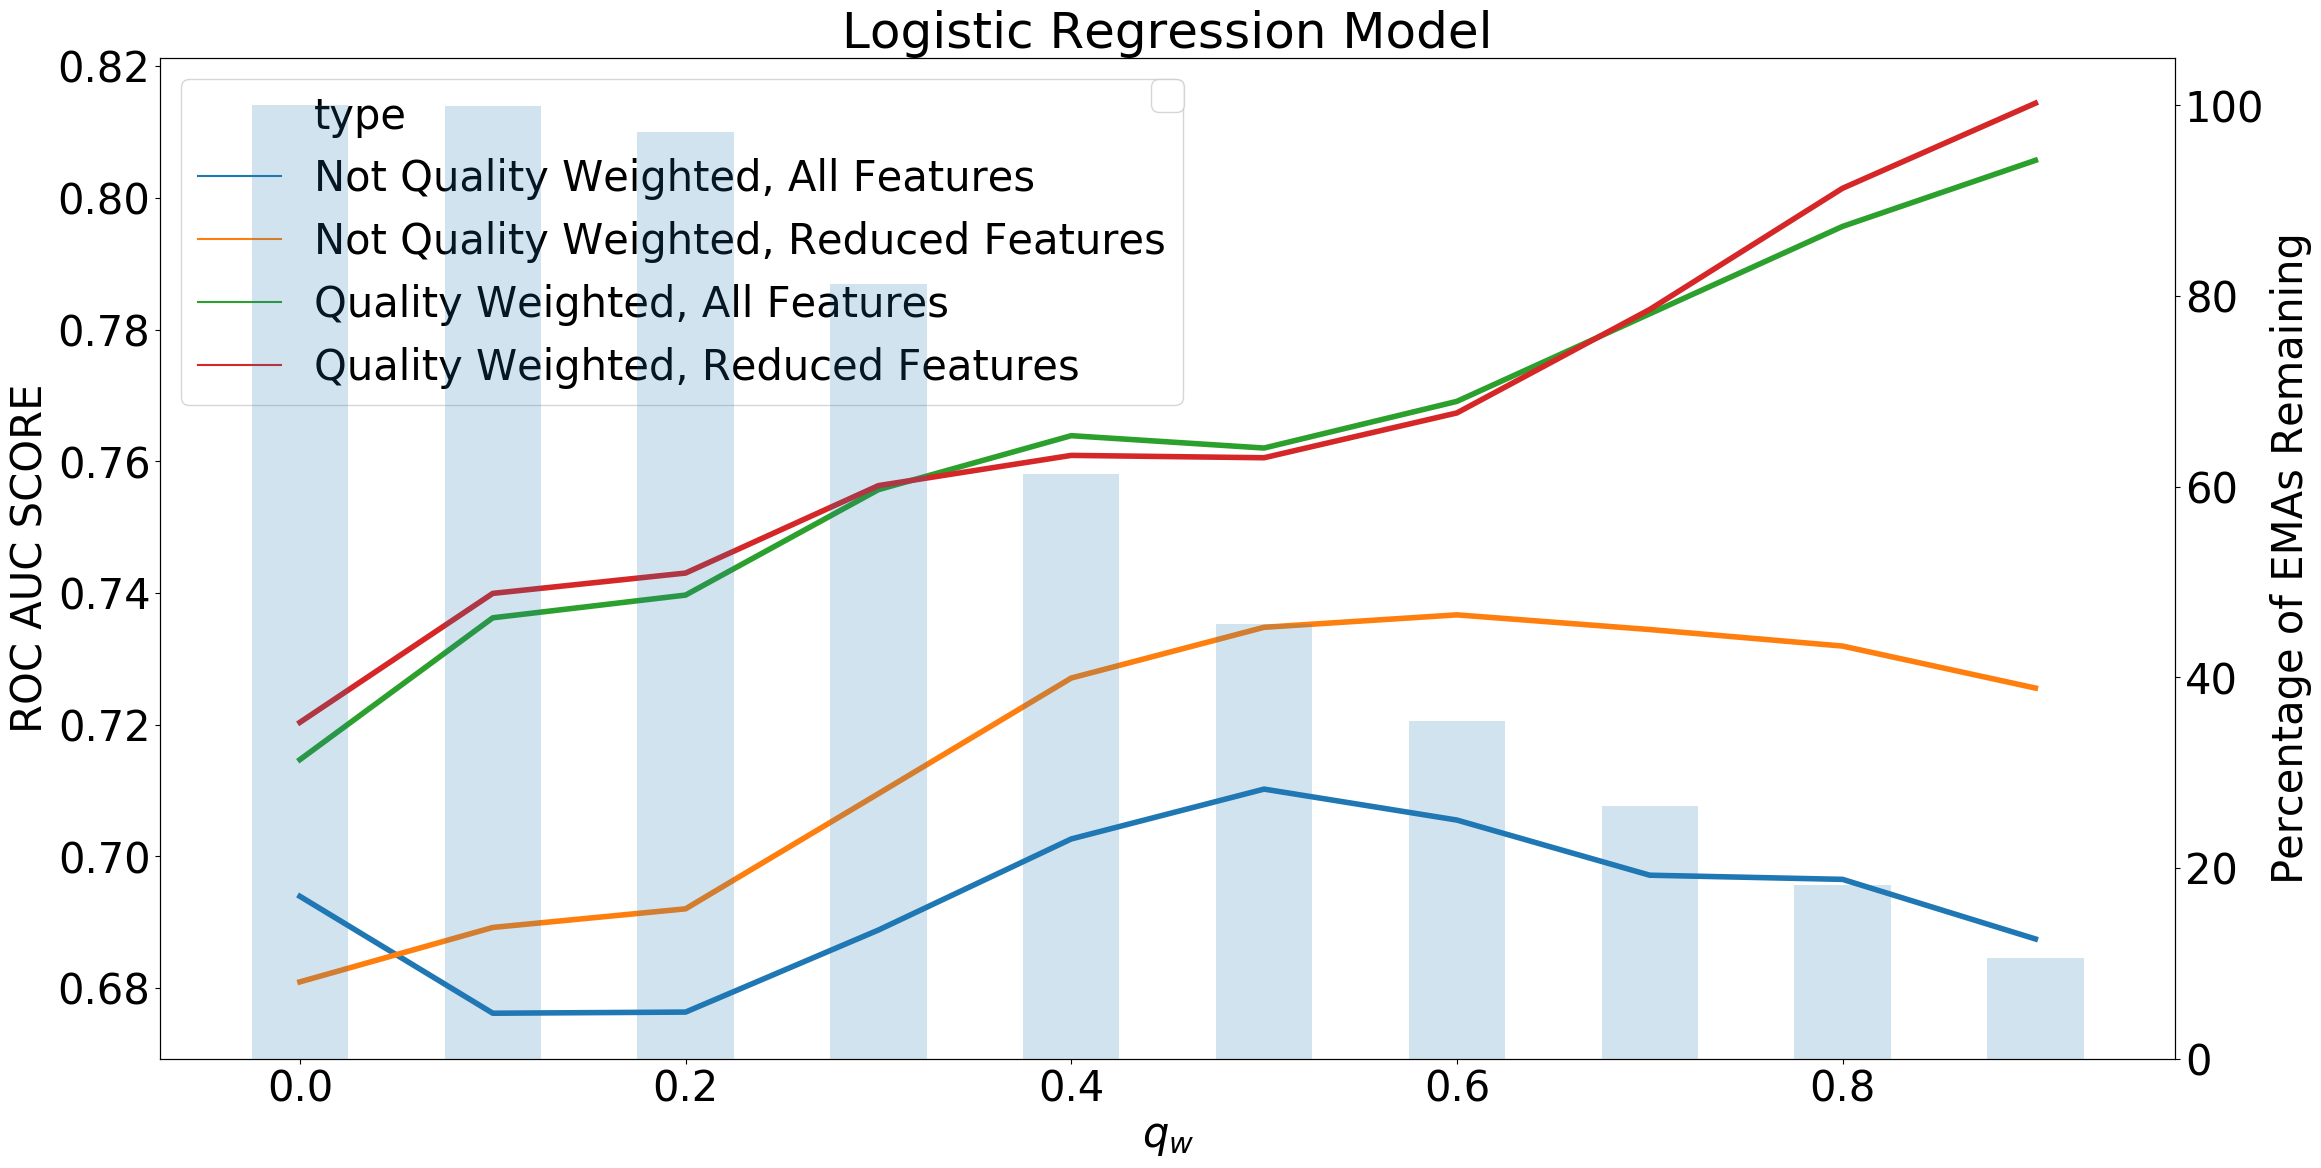

In [355]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
plt.figure(figsize=(26,13))
plt.rcParams.update({'font.size':30})
# sns.barplot(x='qual',y='size',data=df3_qual[df3_qual.feature=='Logistic Regression'],linewidth=4)
plt.xlabel('Signal Quality Threshold \n in Field')

# plt.ylabel('Percentage of EMAs Remaining')
plt.title('Logistic Regression Model')
sns.lineplot(x='qual',y='roc_auc',hue='type',data=df3_qual[df3_qual.feature=='Logistic Regression'],linewidth=4)
plt.xlabel(r'$q_{w}$')
plt.ylabel('ROC AUC SCORE')
axy = plt.gca().twinx()
# axy.scatter(df3_qual[df3_qual.feature=='Logistic Regression']['qual'],df3_qual[df3_qual.feature=='Logistic Regression']['roc_auc'],c = df3_qual[df3_qual.feature=='Logistic Regression']['type'])
axy.bar(df3_qual[(df3_qual.feature=='Logistic Regression')&(df3_qual.type=='Quality Weighted, Reduced Features')]['qual'].values,
        df3_qual[(df3_qual.feature=='Logistic Regression')&(df3_qual.type=='Quality Weighted, Reduced Features')]['size'].values,.05,alpha=.2)
axy.set_ylabel('Percentage of EMAs Remaining')
plt.legend(loc='upper center',ncol=4)

plt.savefig('Logistic_regression.png')
plt.savefig('Logistic_regression.pdf')
# axy.ylim([.65,.82])
# sns.barplot(x='feature',y='size',data=df2_qual[df3_qual.feature=='Logistic Regression'],ax=axy)
plt.show()

In [340]:
df3_qual[(df3_qual.feature=='Logistic Regression')&(df3_qual.type=='Quality Weighted, Reduced Features')]['size']

110  0    100.000000
111  0     99.952714
112  0     97.215047
113  0     81.222115
114  0     61.344801
115  0     45.592405
116  0     35.452300
117  0     26.486614
118  0     18.192668
119  0     10.617698
Name: size, dtype: float64

['20' '80' 'Logistic Regression' 'e1' 'e2' 'e3' 'kurtosis' 'max' 'mean'
 'median' 'skew']


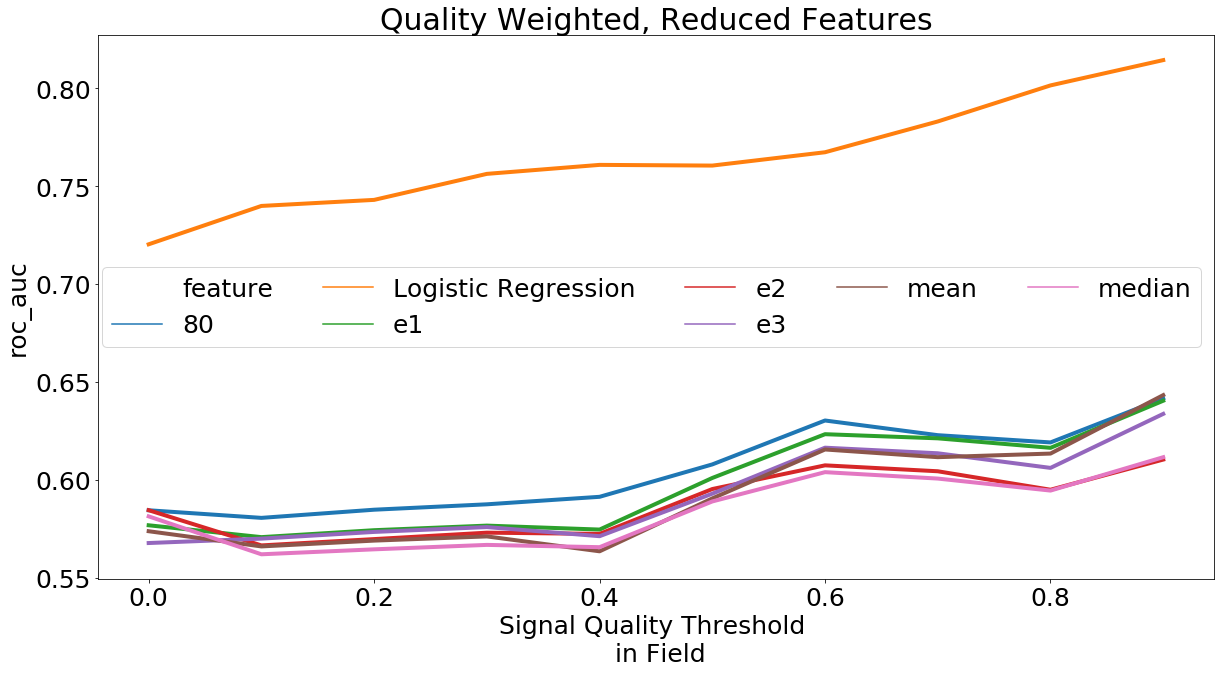

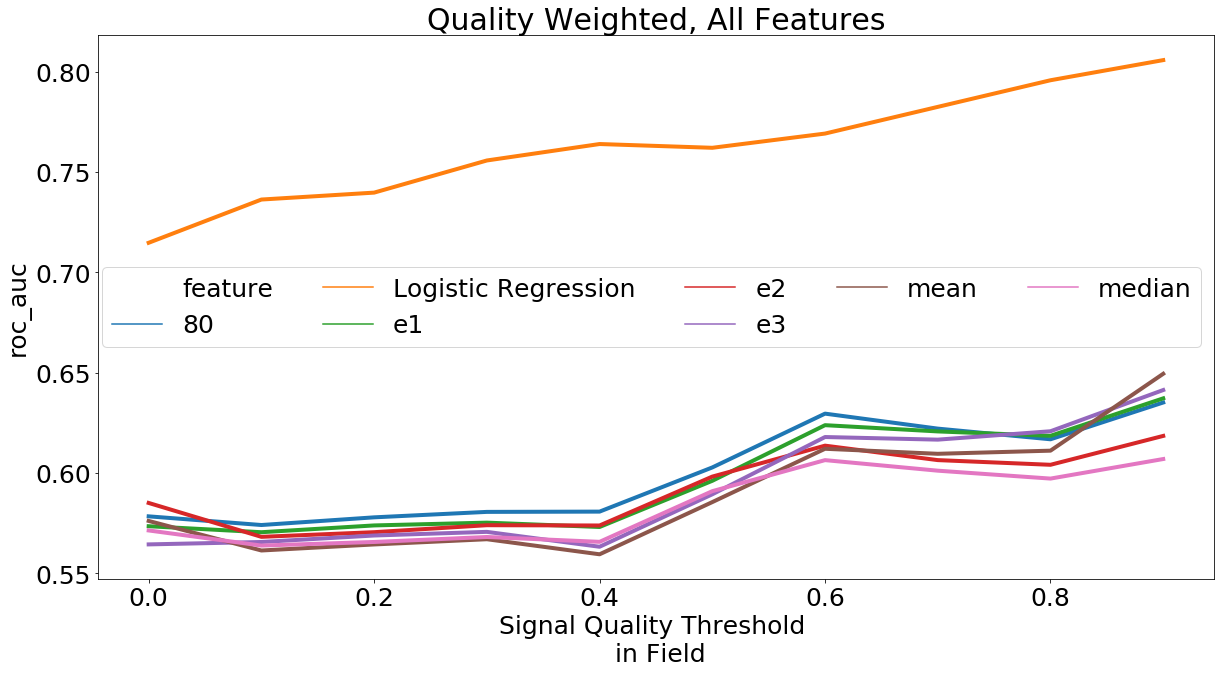

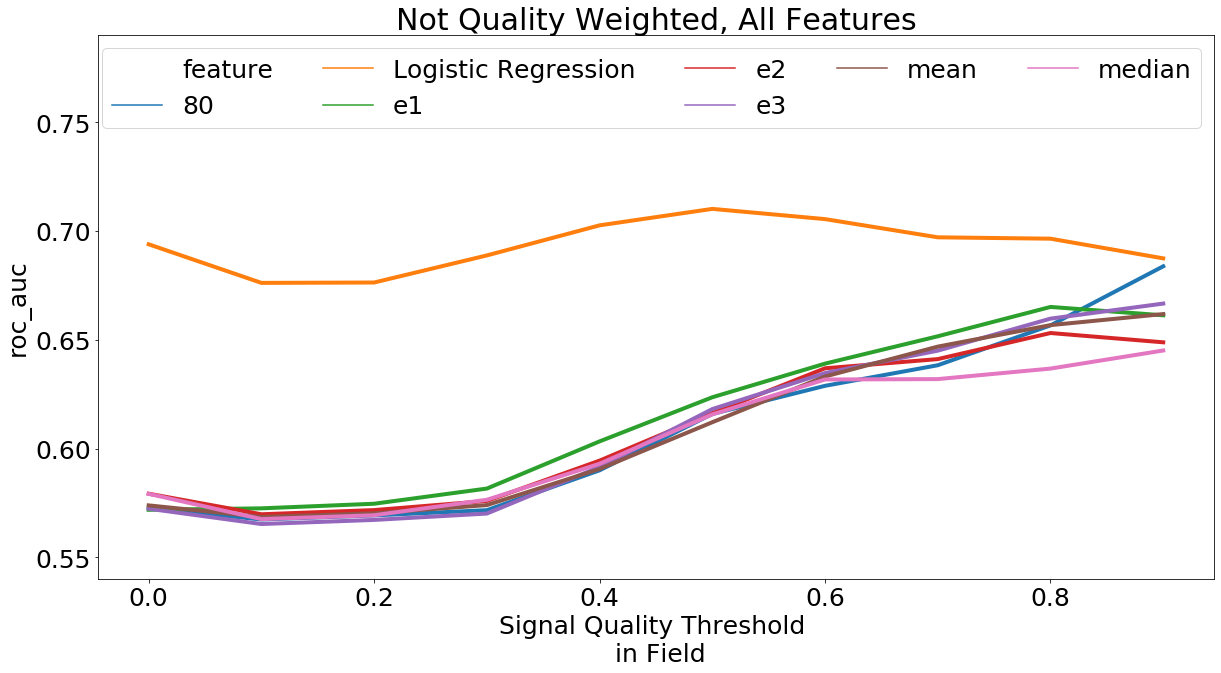

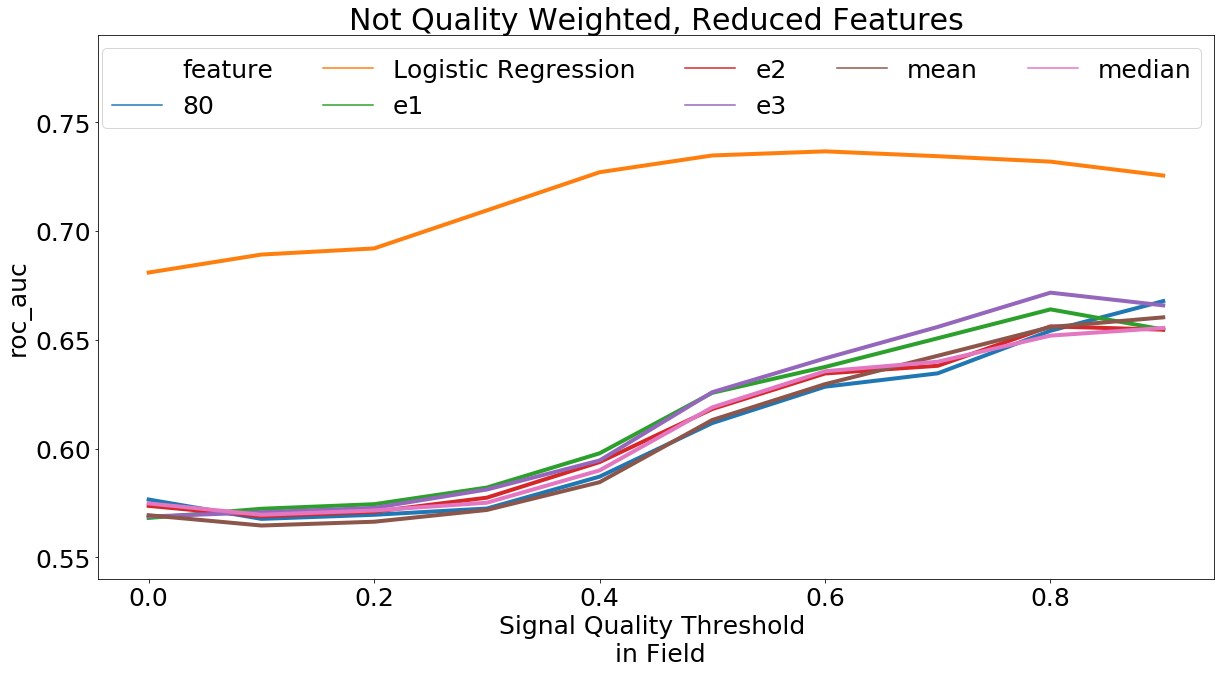

In [320]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(18,10))
# plt.plot(df2_qual[df2_qual['type']=='Not Quality Weighted, All Features']['qual'].values,
#          df2_qual[df2_qual['type']=='Not Quality Weighted, All Features']['roc_auc'].values)
# plt.show()
print(df2_qual['feature'].unique())

# %matplotlib inline
# import seaborn as sns
# import matplotlib.pyplot as plt
# # print(df1.shape,df2.shape)
# plt.rcParams.update({'font.size':20})

df3_qual = df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean','Logistic Regression'])]
plt.figure(figsize=(20,10))
sns.lineplot(x='qual',y='roc_auc',hue='feature',data=df3_qual[df3_qual['type']=='Quality Weighted, Reduced Features'],linewidth=4)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.title('Quality Weighted, Reduced Features')
plt.legend(ncol=5)
plt.savefig('qr1.png')
plt.show()

plt.figure(figsize=(20,10))
sns.lineplot(x='qual',y='roc_auc',hue='feature',data=df3_qual[df3_qual['type']=='Quality Weighted, All Features'],linewidth=4)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.title('Quality Weighted, All Features')
plt.legend(ncol=5)
plt.savefig('qa1.png')
plt.show()

plt.figure(figsize=(20,10))
sns.lineplot(x='qual',y='roc_auc',hue='feature',data=df3_qual[df3_qual['type']=='Not Quality Weighted, All Features'],linewidth=4)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.title('Not Quality Weighted, All Features')
plt.legend(ncol=5)
plt.ylim([.54,.79])
plt.savefig('nqa1.png')
plt.show()

plt.figure(figsize=(20,10))
sns.lineplot(x='qual',y='roc_auc',hue='feature',data=df3_qual[df3_qual['type']=='Not Quality Weighted, Reduced Features'],linewidth=4)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.title('Not Quality Weighted, Reduced Features')
plt.legend(ncol=5)
plt.ylim([.54,.79])
plt.savefig('nqr1.png')
plt.show()



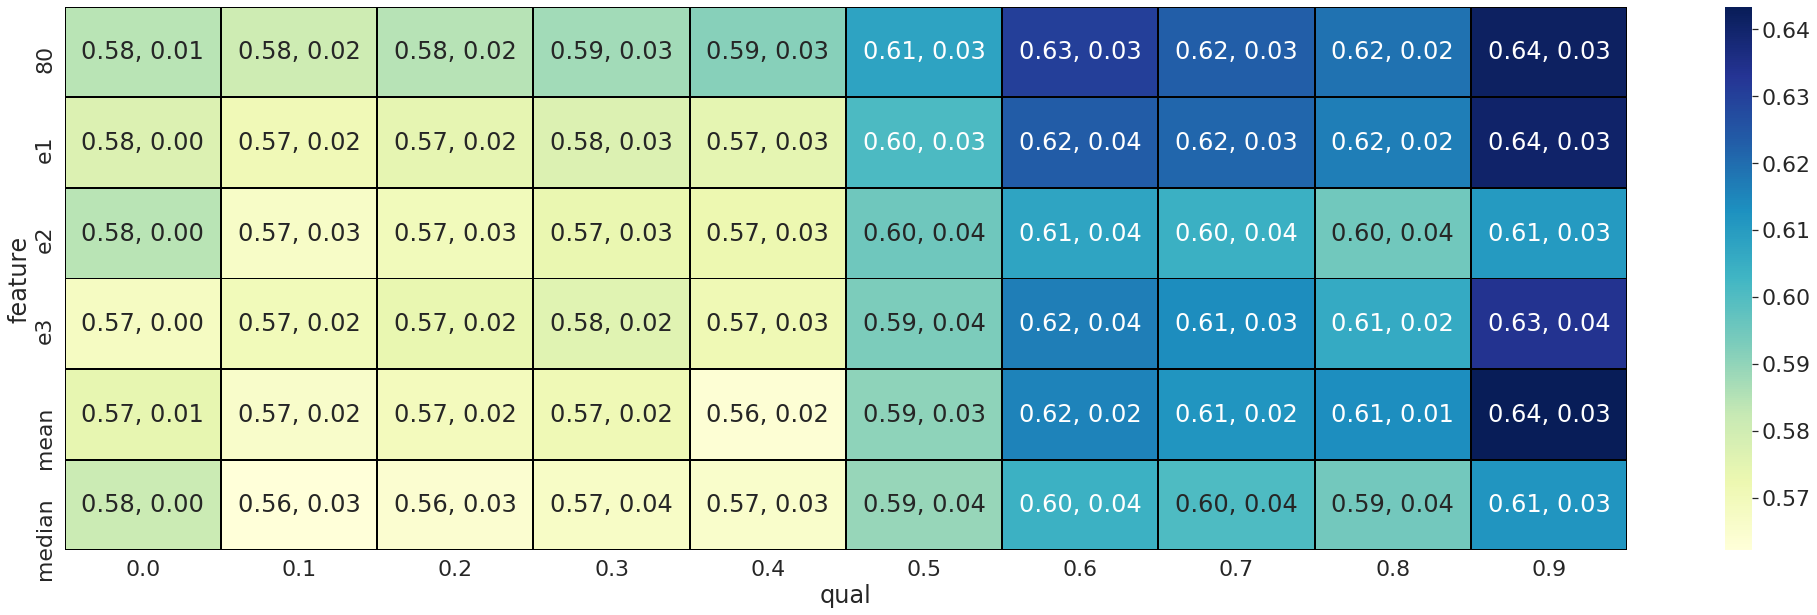

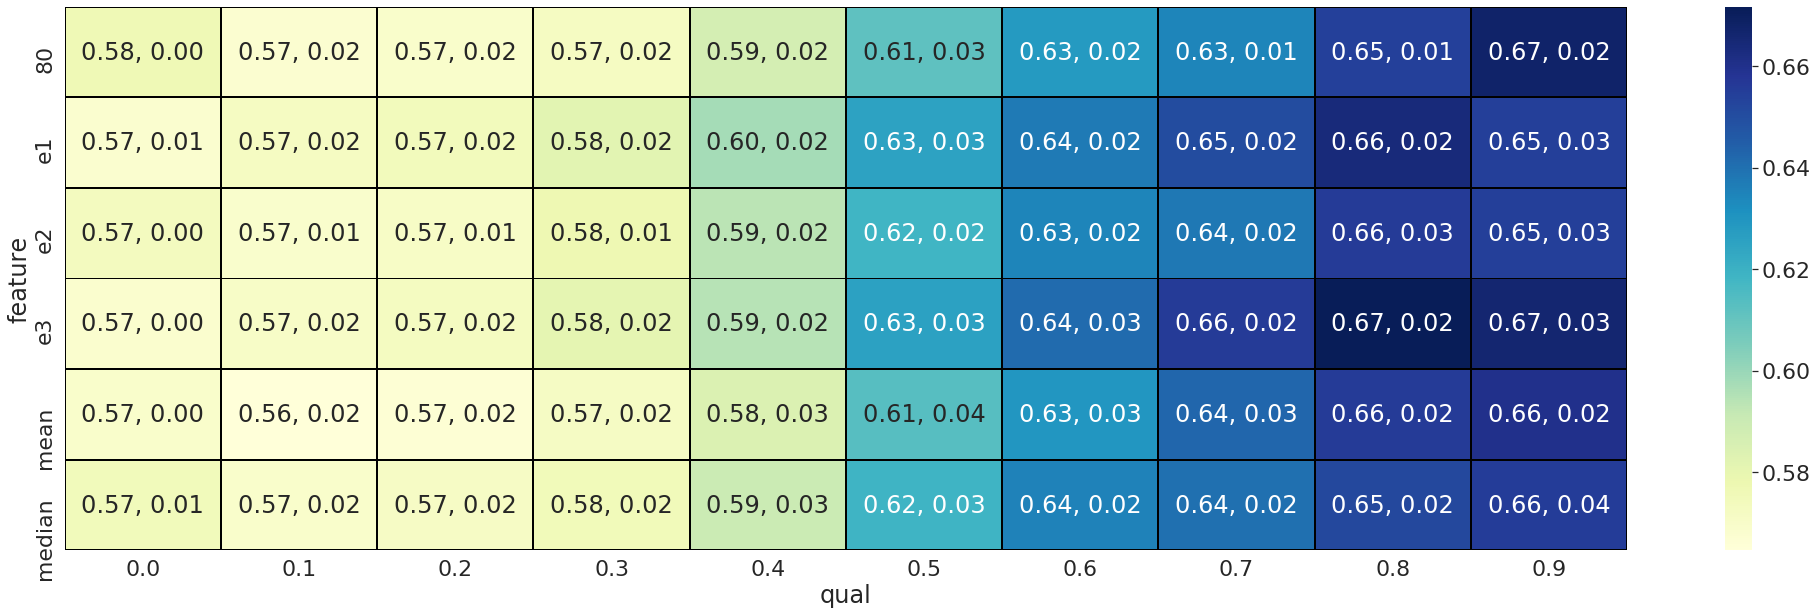

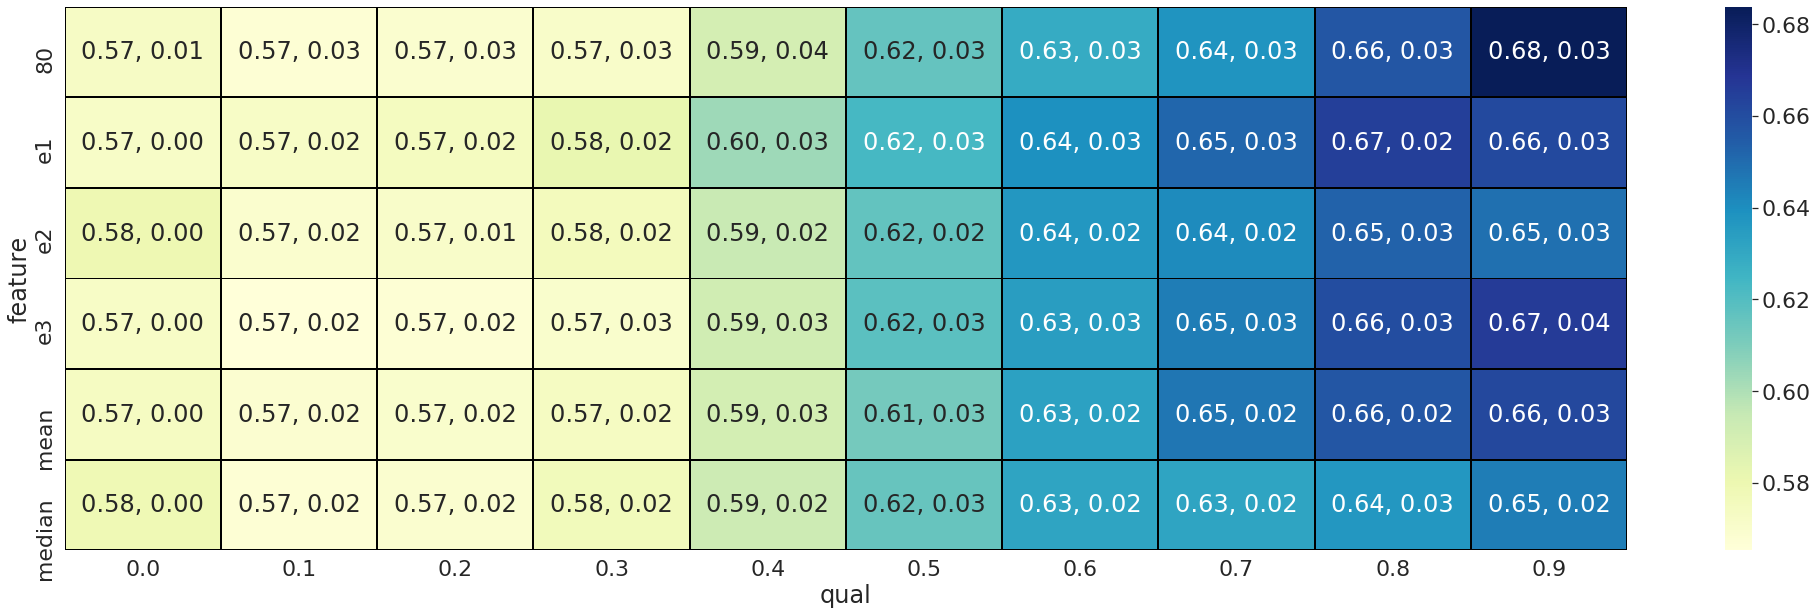

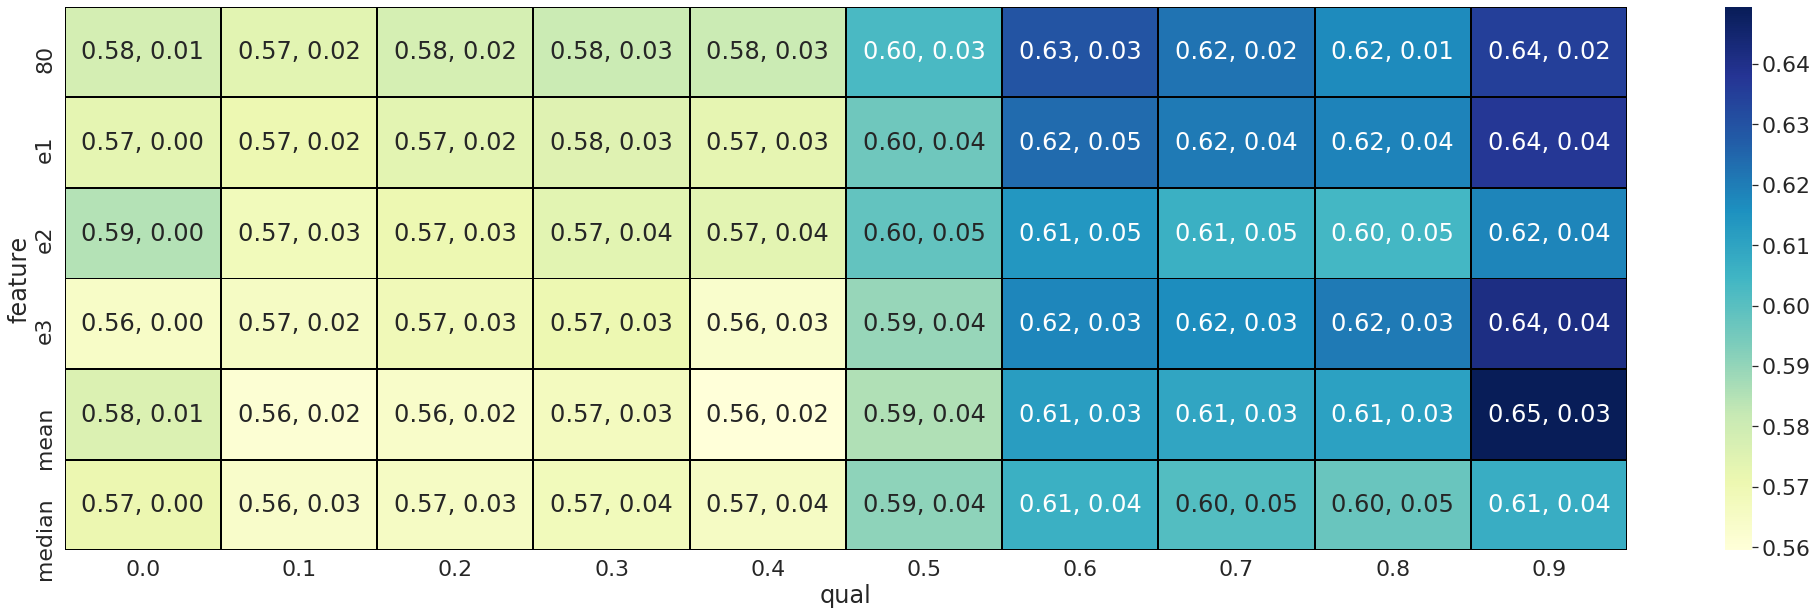

In [326]:
sns.set(font_scale=2)
a = pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Quality Weighted, Reduced Features'],index='feature',columns='qual',values='show',aggfunc=lambda x:''.join(x))
plt.figure(figsize=(35,10))
sns.heatmap(pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Quality Weighted, Reduced Features'],index='feature',columns='qual',values='roc_auc',aggfunc='mean'),
            annot=a,cmap="YlGnBu",fmt='',linewidths=1, linecolor='black')
plt.savefig('qr.png',bbox_inches='tight')
plt.show()
a = pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Not Quality Weighted, Reduced Features'],index='feature',columns='qual',values='show',aggfunc=lambda x:''.join(x))
plt.figure(figsize=(35,10))
sns.heatmap(pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Not Quality Weighted, Reduced Features'],index='feature',columns='qual',values='roc_auc',aggfunc='mean'),
            annot=a,cmap="YlGnBu",fmt='',linewidths=1, linecolor='black')
plt.savefig('nqr.png',bbox_inches='tight')
plt.show()
a = pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Not Quality Weighted, All Features'],index='feature',columns='qual',values='show',aggfunc=lambda x:''.join(x))
plt.figure(figsize=(35,10))
sns.heatmap(pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Not Quality Weighted, All Features'],index='feature',columns='qual',values='roc_auc',aggfunc='mean'),
            annot=a,cmap="YlGnBu",fmt='',linewidths=1, linecolor='black')
plt.savefig('nqa.png',bbox_inches='tight')
plt.show()

a = pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Quality Weighted, All Features'],index='feature',columns='qual',values='show',aggfunc=lambda x:''.join(x))
plt.figure(figsize=(35,10))
sns.heatmap(pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Quality Weighted, All Features'],index='feature',columns='qual',values='roc_auc',aggfunc='mean'),
            annot=a,cmap="YlGnBu",fmt='',linewidths=1, linecolor='black')
plt.savefig('qa.png',bbox_inches='tight')
plt.show()


# plt.figure(figsize=(15,3))
# sns.heatmap(pd.pivot_table(df3_qual[df3_qual.type=='Quality Weighted, All Features'],index='feature',columns='qual',values='roc_auc',aggfunc='median'),annot=True,cmap="YlGnBu",fmt='.2f')
# plt.show()

# plt.figure(figsize=(15,3))
# sns.heatmap(pd.pivot_table(df3_qual[df3_qual.type=='Not Quality Weighted, All Features'],index='feature',columns='qual',values='roc_auc',aggfunc='median'),annot=True,cmap="YlGnBu",fmt='.2f')
# plt.show()
# plt.figure(figsize=(15,3))
# sns.heatmap(pd.pivot_table(df3_qual[df3_qual.type=='Not Quality Weighted, Reduced Features'],index='feature',columns='qual',values='roc_auc',aggfunc='median'),annot=True,cmap="YlGnBu",fmt='.2f')
# plt.show()
# plt.figure(figsize=(15,3))
# sns.heatmap(pd.pivot_table(df2_qual[df2_qual.type=='Quality Weighted, All Features'],index='feature',columns='qual',values='size',aggfunc='median'),annot=True,cmap="YlGnBu",fmt='.2f')
# plt.show()
# # plt.figure(figsize=(20,10))
# # sns.heatmap(pd.pivot_table(df2,index='qual',columns='aux',values='size',aggfunc='median'),annot=True,cmap="Reds",fmt='g')
# # plt.show()
# # # df2.groupby('mean_qual').mean()
# # # df2.info()
# # df2_qual.groupby('qual').count()

In [261]:
df3_qual[df3_qual.type=='Not Quality Weighted, Reduced Features'].feature.unique()

array(['20', '80', 'Logistic Regression', 'e1', 'e2', 'e3', 'kurtosis',
       'max', 'mean', 'median', 'skew'], dtype=object)

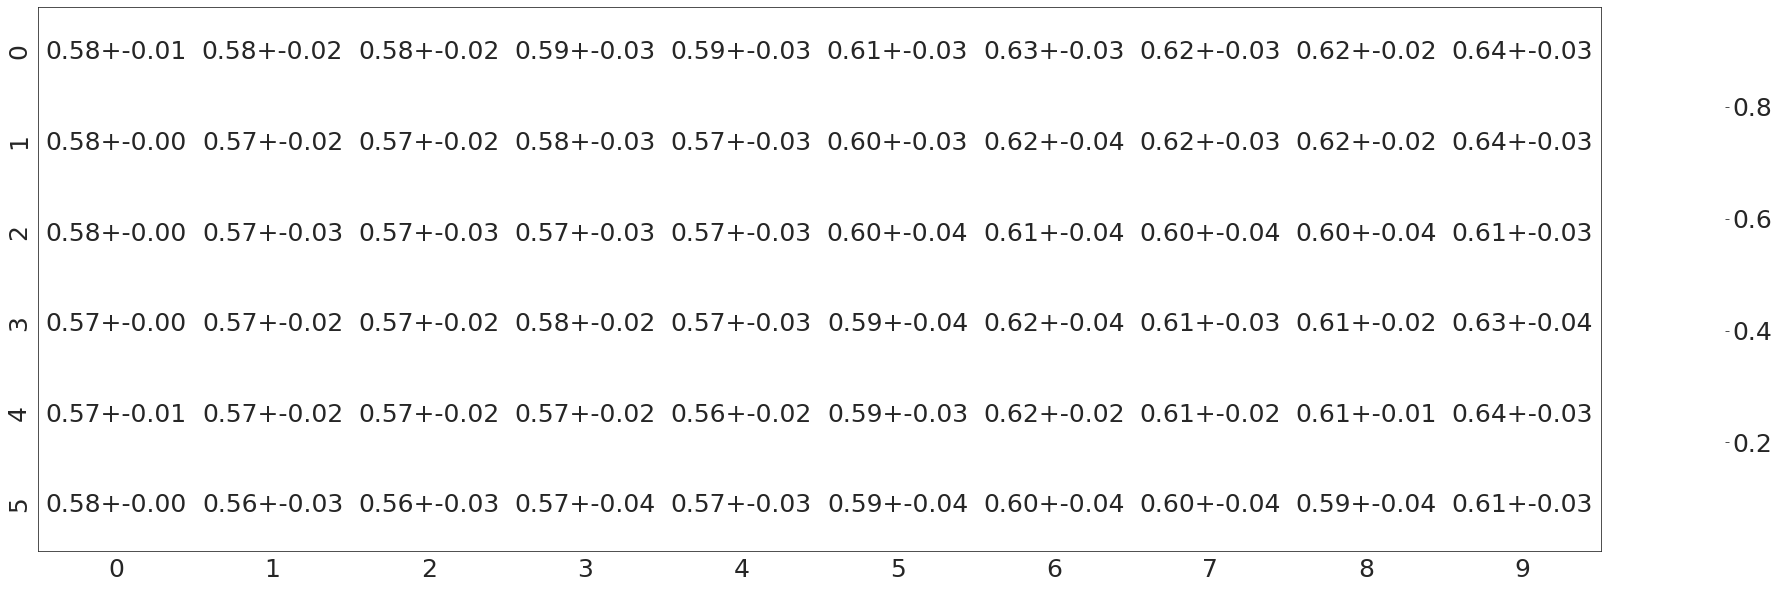

In [297]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=(35,10))
with sns.axes_style('white'):
    ax = sns.heatmap(np.random.rand(6,10)*1, annot=a.values, fmt="",cmap=ListedColormap(['white']),linewidth=5)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
plt.show()

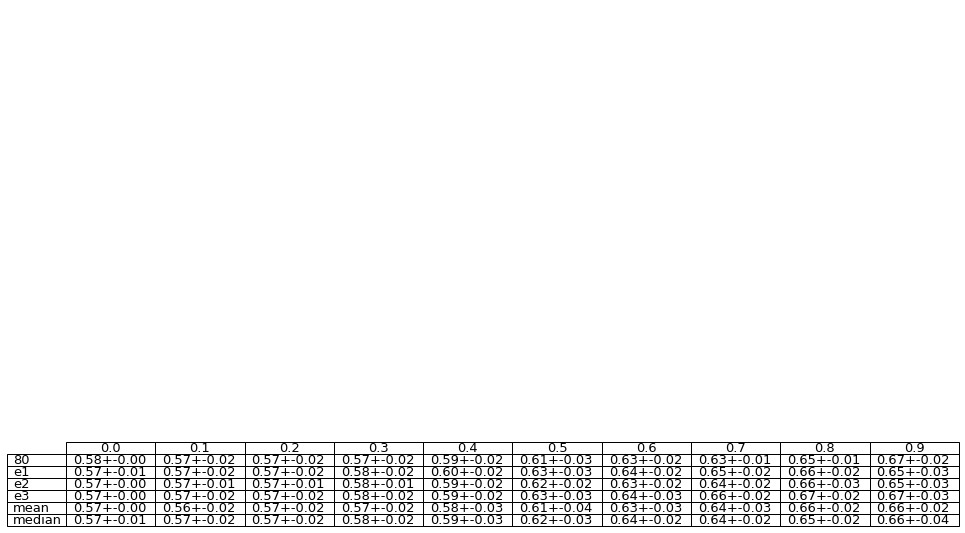

In [304]:
a = pd.pivot_table(df3_qual[df3_qual.feature.isin(['e1','e2','e3','80','median','mean'])][df3_qual.type=='Not Quality Weighted, Reduced Features'],index='feature',columns='qual',values='show',aggfunc=lambda x:''.join(x))
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
plt.figure(figsize=(16,8))
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, a)  # where df is your data frame

plt.savefig('Not Quality Weighted,ReducedFeatures.pdf',bbox_inches='tight')
plt.show()
# import pandas as pd
# import matplotlib.pyplot as plt
# from pandas.tools.plotting import table
# import numpy as np

# dates = pd.date_range('20130101',periods=6)
# df = a

# df.index = [item.strftime('%Y-%m-%d') for item in df.index] # Format date

# fig, ax = plt.subplots(figsize=(12, 2)) # set size frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis
# ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
# tabla = table(ax, df, loc='upper right', colWidths=[0.17]*len(df.columns))  # where df is your data frame
# tabla.auto_set_font_size(False) # Activate set fontsize manually
# tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
# tabla.scale(1.2, 1.2) # change size table
# plt.savefig('table.png', transparent=True)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table
# ax = plt.subplot(111, frame_on=False) # no visible frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis

# table(a, df)  # where df is your data frame

# plt.savefig('mytable.png')
# plt.show()
# import pandas as pd
# import matplotlib.pyplot as plt
# from pandas.tools.plotting import table
# import numpy as np

# dates = pd.date_range('20130101',periods=6)
# df = a

# df.index = [item.strftime('%Y-%m-%d') for item in df.index] # Format date

# fig, ax = plt.subplots(figsize=(12, 2)) # set size frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis
# ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
# tabla = table(ax, df, loc='upper right', colWidths=[0.17]*len(df.columns))  # where df is your data frame
# tabla.auto_set_font_size(False) # Activate set fontsize manually
# tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
# tabla.scale(1.2, 1.2) # change size table
# plt.savefig('table.png', transparent=True)

In [ ]:
plt.figure(figsize=(26,13))
plt.rcParams.update({'font.size':20})
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
# plt.bar(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
# plt.ylabel('Percentage of EMAs Remaining')
plt.title('Logistic Regression Model')
# axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.barplot(x='qual',y='roc_auc',hue='type',data=df4_qual,linewidth=4)
plt.legend(loc='upper center',ncol=2)
plt.ylim([.5,.9])
plt.show()
# df2_qual[df2

In [ ]:
plt.figure(figsize=(26,13))
plt.rcParams.update({'font.size':20})
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
# plt.bar(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
# plt.ylabel('Percentage of EMAs Remaining')
plt.title('Logistic Regression Model')
# axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.barplot(x='qual',y='roc_auc',hue='type',data=df2_qual[df2_qual.feature=='Logistic Regression'],linewidth=4)
plt.legend(loc='upper center',ncol=2)
plt.ylim([.5,.9])
plt.show()
# df2_qual[df2_qual.feature=='Logistic Regression']

In [ ]:
plt.figure(figsize=(26,13))
plt.rcParams.update({'font.size':20})
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
# plt.bar(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
# plt.ylabel('Percentage of EMAs Remaining')
plt.title('Logistic Regression Model')
# axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.lineplot(x='qual',y='roc_auc',hue='window_size',data=df2_qual[(df2_qual.feature=='Logistic Regression')&(df2_qual['type']=='Quality Weighted, Reduced Features')],linewidth=4)
plt.legend(loc='upper center',ncol=2)
plt.ylim([.5,.9])

In [ ]:
# import matplotlib.pyplot as plt
df2_qual = df2_qual[df2_qual.window_size==20].sort_values('qual').reset_index(drop=True)
# plt.figure(figsize=(18,10))
# plt.plot(df2_qual[df2_qual['type']=='Not Quality Weighted, All Features']['qual'].values,
#          df2_qual[df2_qual['type']=='Not Quality Weighted, All Features']['roc_auc'].values)
# plt.show()
print(df2_qual['feature'].unique())

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# print(df1.shape,df2.shape)
plt.rcParams.update({'font.size':20})


plt.figure(figsize=(20,10))
sns.lineplot(x='qual',y='roc_auc',hue='feature',data=df2_qual[df2_qual['type']=='Quality Weighted, Reduced Features'],linewidth=4)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.title('Quality Weighted, Reduced Features')
plt.legend(ncol=5)
plt.show()

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# print(df1.shape,df2.shape)
plt.rcParams.update({'font.size':20})

plt.figure(figsize=(20,10))
sns.lineplot(x='qual',y='roc_auc',hue='feature',data=df2_qual[df2_qual['type']=='Quality Weighted, All Features'],linewidth=4)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.title('Quality Weighted, All Features')
plt.legend(ncol=5)
plt.show()

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# print(df1.shape,df2.shape)
plt.rcParams.update({'font.size':20})

plt.figure(figsize=(23,10))
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
plt.bar(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.ylabel('Percentage of EMAs Remaining')
plt.title('Logistic Regression Model')
axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.lineplot(x='qual',y='roc_auc',hue='type',data=df2_qual[df2_qual.feature=='Logistic Regression'],linewidth=4,ax=axy)
plt.legend(loc='upper center',ncol=2)

plt.show()

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# print(df1.shape,df2.shape)
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(23,10))
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
plt.bar(df2_qual[df2_qual.feature=='max']['qual'],df2_qual[df2_qual.feature=='max']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.ylabel('Percentage of EMAs Remaining')
plt.title('Single Feature Summary = Maximum')
axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.lineplot(x='qual',y='roc_auc',hue='type',data=df2_qual[df2_qual.feature=='max'],linewidth=4,ax=axy)
plt.legend(loc='upper center',ncol=2)

plt.show()

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# print(df1.shape,df2.shape)
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(23,10))
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
plt.bar(df2_qual[df2_qual.feature=='80']['qual'],df2_qual[df2_qual.feature=='80']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.ylabel('Percentage of EMAs Remaining')
plt.title('Single Feature Summary = 80th Percentile')
axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.lineplot(x='qual',y='roc_auc',hue='type',data=df2_qual[df2_qual.feature=='80'],linewidth=4,ax=axy)
plt.legend(loc='upper center',ncol=2)

plt.show()

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# print(df1.shape,df2.shape)
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(23,10))
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
plt.bar(df2_qual[df2_qual.feature=='median']['qual'],df2_qual[df2_qual.feature=='median']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.ylabel('Percentage of EMAs Remaining')
plt.title('Single Feature Summary = Median')
axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.lineplot(x='qual',y='roc_auc',hue='type',data=df2_qual[df2_qual.feature=='median'],linewidth=4,ax=axy)
plt.legend(loc='upper center',ncol=2)
plt.show()


%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# print(df1.shape,df2.shape)
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(23,10))
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
plt.bar(df2_qual[df2_qual.feature=='mean']['qual'],df2_qual[df2_qual.feature=='mean']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.ylabel('Percentage of EMAs Remaining')
plt.title('Single Feature Summary = Mean')
axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.lineplot(x='qual',y='roc_auc',hue='type',data=df2_qual[df2_qual.feature=='mean'],linewidth=4,ax=axy)
plt.legend(loc='upper center',ncol=2)
plt.show()


%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# print(df1.shape,df2.shape)
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(23,10))
# sns.barplot(x='qual',y='size',data=df2_qual,linewidth=4)
plt.bar(df2_qual[df2_qual.feature=='20']['qual'],df2_qual[df2_qual.feature=='20']['size'],.05,alpha=.2)
plt.xlabel('Signal Quality Threshold \n in Field')
plt.ylabel('Percentage of EMAs Remaining')
plt.title('Single Feature Summary = 20th Percentile')
axy = plt.gca().twinx()
# axy.scatter(df2_qual[df2_qual.feature=='Logistic Regression']['qual'],df2_qual[df2_qual.feature=='Logistic Regression']['roc_auc'],c = df2_qual[df2_qual.feature=='Logistic Regression']['type'])
sns.lineplot(x='qual',y='roc_auc',hue='type',data=df2_qual[df2_qual.feature=='20'],linewidth=4,ax=axy)
plt.legend(loc='upper center',ncol=2)
plt.show()
# plt.figure(figsize=(20,10))
# sns.barplot(x='qual',y='roc_auc',hue='feature',data=df2_qual_best,linewidth=4)
# plt.legend(ncol=5)
# plt.show()
# plt.figure(figsize=(20,10))
# sns.boxplot(x='qual',y='size',data=df2)
# plt.legend(ncol=5)
# plt.show()
# plt.figure(figsize=(20,10))
# sns.barplot(x='aux',y='roc_auc',data=df2_aux_best,linewidth=4)
# plt.legend(ncol=5)
# plt.show()
# plt.figure(figsize=(20,10))
# sns.boxplot(x='window_size',y='roc_auc',hue='mean',data=df2[(df2.window_size>50)&(df2.window_size<150)])
# plt.legend(ncol=5)
# plt.show()
# plt.figure(figsize=(20,10))
# sns.boxplot(x='window_size',y='roc_auc',hue='mean',data=df2[(df2.window_size>100)&(df2.window_size<150)])
# plt.legend(ncol=5)
# plt.show()
# plt.figure(figsize=(20,10))
# sns.boxplot(x='window_size',y='roc_auc',hue='mean',data=df2[(df2.window_size>0)&(df2.window_size<150)])
# plt.legend(ncol=5)
# plt.show()
# plt.figure(figsize=(20,10))
# sns.boxplot(x='window_size',y='roc_auc',hue='mean',data=df2[(df2.window_size>150)])
# plt.legend(ncol=5)
# plt.show()
# df2.reset_index(drop=True).pivot('mean_qual','mean_aux','roc_auc')
# plt.figure(figsize=(20,10))
# sns.heatmap(pd.pivot_table(df2,index='qual',columns='feature',values='roc_auc',aggfunc='mean'),annot=True,cmap="YlGnBu")
# plt.show()
plt.figure(figsize=(15,3))
sns.heatmap(pd.pivot_table(df2_qual[df2_qual.type=='Quality Weighted, Reduced Features'],index='feature',columns='qual',values='roc_auc',aggfunc='median'),annot=True,cmap="YlGnBu",fmt='.2f')
plt.show()
plt.figure(figsize=(15,3))
sns.heatmap(pd.pivot_table(df2_qual[df2_qual.type=='Quality Weighted, All Features'],index='feature',columns='qual',values='roc_auc',aggfunc='median'),annot=True,cmap="YlGnBu",fmt='.2f')
plt.show()
plt.figure(figsize=(15,3))
sns.heatmap(pd.pivot_table(df2_qual[df2_qual.type=='Quality Weighted, All Features'],index='feature',columns='qual',values='size',aggfunc='median'),annot=True,cmap="YlGnBu",fmt='.2f')
plt.show()
# plt.figure(figsize=(20,10))
# sns.heatmap(pd.pivot_table(df2,index='qual',columns='aux',values='size',aggfunc='median'),annot=True,cmap="Reds",fmt='g')
# plt.show()
# # df2.groupby('mean_qual').mean()
# # df2.info()
# df2_qual.groupby('qual').count()

In [ ]:
print(df['user'].unique().shape)
df1 = df.groupby(['type','feature','window_size'],as_index=False).median()

In [ ]:
def get_max_auc(df):
    df = df.sort_values('auc').reset_index(drop=True)
    df = df.loc[df.shape[0]-1]
    return df

some_data = df1.groupby(['feature','type'],as_index=False).apply(get_max_auc)

In [ ]:
some_data

In [ ]:
tt = df1.groupby(['type','feature','window_size'],as_index=False).max().sort_values('auc').reset_index(drop=True)

In [ ]:
plt.figure(figsize=(18,20))
plt.rcParams.update({'font.size':20})
sns.barplot(x='feature',y='auc',hue='type',data=tt)
plt.xticks(rotation=10)
plt.legend(ncol=2)

In [ ]:
tt1 = tt[(tt.feature=='Logistic Regression')&(tt['type']=='Quality Weighted, Reduced Features')].sort_values('auc').reset_index(drop=True)
tt1

In [ ]:
plt.figure(figsize=(18,10))
sns.barplot(x='window_size',y='auc',data=tt1)
plt.title('AUC score in different window sizes for Logistic Regression Model')
plt.xticks(rotation=50)

In [ ]:
some_data = some_data[some_data['type']=='Quality Weighted, All Features'].sort_values('auc').reset_index(drop=True)
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(18,10))
plt.bar(some_data['feature'],some_data['auc'],.5)
plt.ylabel('Median F1')
plt.xticks(range(some_data.shape[0]),[row['feature']+'\n'+str(row['window_size'])+' minutes' for i,row in some_data.iterrows()],rotation=60)
plt.show()

In [ ]:
plt.figure(figsize=(18,10))
# df2['index'] = 
sns.barplot(x='user',y='auc',data=df[(df.feature=='Logistic Regression')&(df.window_size==10)&(df['type']=='Quality Weighted, All Features')].sort_values('auc'))
plt.hlines(.5,0,15)
plt.hlines(.668,0,15,color='r')
plt.title('Logistic Regression Best Model Performance, across all users')
plt.xticks([])
# plt.legend(ncol=10)

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import RobustScaler
# from ecg import ecg_feature_computation
import matplotlib.pyplot as plt
# from hrvanalysis import get_time_domain_features,get_geometrical_features,get_csi_cvi_features,get_poincare_plot_features
# from hrvanalysis import get_frequency_domain_features
from typing import List
import numpy as np
import scipy.signal as signal
from copy import deepcopy
import datetime
import numpy as np
from scipy.stats import iqr
from enum import Enum
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,roc_auc_score,f1_score,roc_curve,auc,precision_score,recall_score,accuracy_score,classification_report,make_scorer,precision_recall_curve
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from joblib import Parallel,delayed
from sklearn.preprocessing import StandardScaler

In [ ]:
def f1Bias_scorer_CV(probs, y, ret_bias=False):

    precision, recall, thresholds = precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and precision[i]>recall[i]-.1:
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def my_score_auc(y_true,y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return auc(fpr,tpr)    

def get_results(X,y,groups):
    my_score = make_scorer(my_score_auc,needs_threshold=True)
    delta = 0.1
    paramGrid = {'rf__kernel': ['rbf'],
                 'rf__C': [10,1,100,200],
                 'rf__gamma': [np.power(2,np.float(x)) for x in np.arange(-6, -2, .25)],
                 'rf__class_weight': [{0: w, 1: 1 - w} for w in [.2,.3,.25,.35]],
                 'rf__probability':[True]
    }
    pca = PCA(n_components=4)
    clf = Pipeline([('sts',StandardScaler()),('rf', SVC())])
    gkf = GroupKFold(n_splits=len(np.unique(groups)))
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                               scoring=my_score,verbose=5)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    probs = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    print(roc_auc_score(y,probs),a,b,'rr')
    probs[probs>=b] = 1
    probs[probs<b] = 0
    y_pred = np.int64(probs)
    print(classification_report(y,y_pred),confusion_matrix(y,y_pred))
#     clf.fit(X,y)
    return np.array([f1_score(y,y_pred),roc_auc_score(y,y_pred),recall_score(y,y_pred)])

In [ ]:
def get_user_results(df):
    print(df['duration'].unique())
    qual = df['q'].values[0]
    groups = np.array(list(df['user']))
    X = np.array(list(df['feature']))
    y = np.array(list(df['label']))
    duration = df['duration'].values[0]
    print(duration,qual)
    arr = get_results(X,y,groups)
    return pd.DataFrame([[duration,qual,arr[0],arr[1],arr[2]]],columns=['duration','quality','f1','precision','recall'])

In [ ]:
import numpy as np
def get_results_qual(data_global,q):
    data_global1 = deepcopy(data_global[data_global.quality>=q]).reset_index(drop=True)
    print(data_global1['duration'].unique())
    print(data_global1.shape,data_global.shape)
    data_global1['q'] = q
    data_d = data_global1.groupby('duration',as_index=False).apply(get_user_results)
    return data_d
from joblib import Parallel,delayed
# all_data = Parallel(n_jobs=-1,verbose=3)(delayed(get_results_qual)(data_global,q) for q in np.arange(0,.5,.05))
all_data = [get_results_qual(data_global,q) for q in np.arange(0,.5,.05)]

In [ ]:
results = pd.concat(all_data)

In [ ]:
results.groupby('quality').max()